<a href="https://colab.research.google.com/github/adamserag1/Interpretability-for-VRDU-models/blob/main/notebooks/LayoutLM3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Layout LMv3

## Imports

In [1]:
# UNCOMMNET FOR USE IN COLAB
!git clone https://github.com/adamserag1/Interpretability-for-VRDU-models.git

Cloning into 'Interpretability-for-VRDU-models'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 27 (delta 7), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 670.43 KiB | 4.22 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [2]:
!pip install datasets seqeval evaluate transformers torch

  Using cached datasets-3.5.0-py3-none-any.whl.metadata (19 kB)
  Using cached seqeval-1.2.2.tar.gz (43 kB)
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/20

In [3]:
from transformers import AutoProcessor, LayoutLMv3ForTokenClassification, set_seed
from PIL import Image,ImageDraw, ImageFont
from datasets import load_dataset
import torch
import pandas as pd
import evaluate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

set_seed(0)

## Setup

### Data

In [13]:
funsd = load_dataset("nielsr/funsd", trust_remote_code=True)
funsd_train = funsd["train"]
labels = funsd_train.features["ner_tags"].feature.names
id2label = {v: k for v, k in enumerate(labels)}
label2id = {v: k for k, v in enumerate(labels)}
print(id2label)
print(label2id)

{0: 'O', 1: 'B-HEADER', 2: 'I-HEADER', 3: 'B-QUESTION', 4: 'I-QUESTION', 5: 'B-ANSWER', 6: 'I-ANSWER'}
{'O': 0, 'B-HEADER': 1, 'I-HEADER': 2, 'B-QUESTION': 3, 'I-QUESTION': 4, 'B-ANSWER': 5, 'I-ANSWER': 6}


In [14]:
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

In [15]:
def encode(example):
  images = [Image.open(path).convert("RGB") for path in example["image_path"]]
  words = example["words"]
  boxes = example["bboxes"]
  labels = example["ner_tags"]
  encoding = processor(images,
                       words,
                       boxes=boxes,
                       word_labels=labels,
                       padding="max_length",
                       truncation=True,
                       return_tensors="pt")
  return encoding

In [16]:
# 80:20 Train : Validate
split = funsd["train"].train_test_split(test_size=0.2)
train_dataset = split["train"]
val_dataset = split["test"]

train_dataset = train_dataset.map(encode, batched=True, remove_columns=funsd["train"].column_names)
val_dataset = val_dataset.map(encode, batched=True, remove_columns=funsd["train"].column_names)

Map:   0%|          | 0/119 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

### Finetuning

In [17]:
metric = evaluate.load("seqeval")
import numpy as np
def compute_metrics(p):
  predictions, labels = p
  predictions = np.argmax(predictions, axis=2)

  true_preds = [
      [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, labels)
  ]
  true_labels = [
      [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, labels)
  ]
  results = metric.compute(predictions=true_preds, references=true_labels)

  return {
      "precision": results["overall_precision"],
      "recall": results["overall_recall"],
      "f1": results["overall_f1"],
      "accuracy": results["overall_accuracy"],
  }

In [18]:
from huggingface_hub import login
login()

In [ ]:
from transformers import TrainingArguments, Trainer
output_dir = "./layoutlmv3-finetuned-funsd"
model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base", num_labels=len(labels), id2label=id2label, label2id=label2id)
training_args = TrainingArguments(
    output_dir=output_dir,
    max_steps=1000,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=1e-5,
    eval_strategy="steps",
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)
## Chat gpt i want to save to hub etc.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor,
    compute_metrics=compute_metrics,
)

trainer.train()

In [22]:
trainer.push_to_hub("adamadam111/layoutlmv3bfinetuned-funsd-01")
processor.push_to_hub("adamadam111/layoutlmv3b-finetuned-funsd-01")

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

events.out.tfevents.1745497194.449b82089260.192.0:   0%|          | 0.00/5.61k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

events.out.tfevents.1745497238.449b82089260.192.1:   0%|          | 0.00/8.65k [00:00<?, ?B/s]

events.out.tfevents.1745497883.449b82089260.192.2:   0%|          | 0.00/11.1k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/adamadam111/layoutlmv3b-finetuned-funsd-01/commit/19d9dae17f379b4fbe8b18f0c8a0bcdf04cd4c71', commit_message='Upload processor', commit_description='', oid='19d9dae17f379b4fbe8b18f0c8a0bcdf04cd4c71', pr_url=None, repo_url=RepoUrl('https://huggingface.co/adamadam111/layoutlmv3b-finetuned-funsd-01', endpoint='https://huggingface.co', repo_type='model', repo_id='adamadam111/layoutlmv3b-finetuned-funsd-01'), pr_revision=None, pr_num=None)

In [40]:
predictions = logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

predictions = [p for p, l in zip(predictions, labels) if l != 100]
labels = [l for l in labels if l != 100]

width, height = image.size

def denormalize_box(bbox, width, height):
  return [
      width * (bbox[0] / 1000),
      height * (bbox[1] / 1000),
      width * (bbox[2] / 1000),
      height * (bbox[3] / 1000),
  ]

true_preds = [id2label[pred] for pred in predictions]
true_boxes = [denormalize_box(box, width, height) for box in token_boxes]

print(true_preds)
print(len(example["ner_tags"]))
print(len(logits.argmax(-1).squeeze().tolist()))
count = 0
correct = 0
for idx, pred in enumerate(predictions):
  if pred == example["ner_tags"][idx]:
    correct += 1
  count += 1

accuracy = correct/count
print(accuracy)


['I-HEADER', 'B-HEADER', 'B-QUESTION', 'O', 'I-QUESTION', 'B-QUESTION', 'I-ANSWER']
223
360
0.0


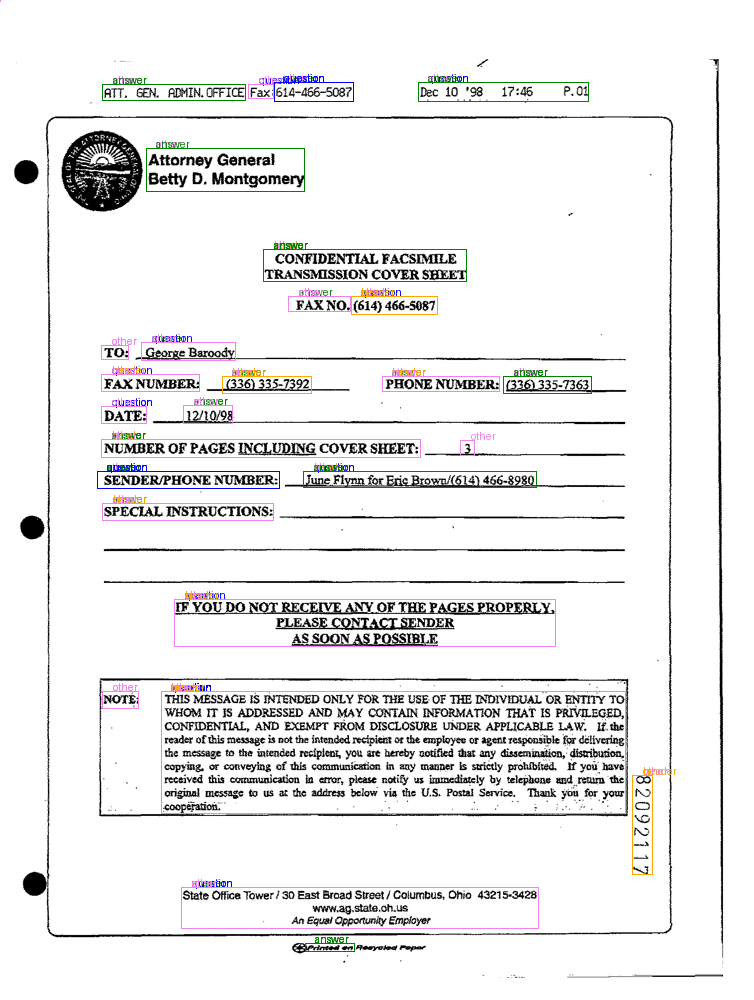

In [16]:
draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
        return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(true_preds, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text(
        (box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font
    )

image